In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import math

import matplotlib.patches as mpatches
import matplotlib.lines as mlines

import ipywidgets as widgets
from IPython.display import clear_output, display

import textwrap

import locale
locale.setlocale(locale.LC_ALL, 'en_IN.UTF-8')
format_currency = lambda x: locale.format_string('₹%d', x, grouping=True)

In [2]:
df = pd.read_csv("store_data.csv")

In [3]:
# data cleaning and feature engineering

final_df = df.copy()

# combining date and time to create datetime
final_df["PaymentDateTime"] = pd.to_datetime(final_df["PaymentDate"] + " " + final_df["PaymentTime"])
final_df = final_df.drop(columns=["PaymentDate", "PaymentTime"])

final_df[["SellingPrice", "Product_Description"]] = final_df["Description"].str.split(" ", n=1, expand=True)
final_df["SellingPrice"] = final_df["SellingPrice"].astype(int)

In [4]:
def description_feature_engineering(desc_string):
    # first colour of product
    colors = ["Black", "Blue", "Dark Green", "Brown", "Grey", "Purple", "White", "Red"]
    matched_color = None
    for color in colors:
        if color in desc_string:
            matched_color = color
            desc_string = desc_string.replace(matched_color, "")
            break

    # gender and age group
    matched_gender = None
    matched_agegroup = None
    if "Girl" in desc_string:
        matched_gender = "Female"
        matched_agegroup = "Girl"
        desc_string = desc_string.replace(matched_agegroup, "")
    elif "Ladies" in desc_string:
        matched_gender = "Female"
        matched_agegroup = "Ladies"
        desc_string = desc_string.replace(matched_agegroup, "")
    elif "Boy" in desc_string:
        matched_gender = "Male"
        matched_agegroup = "Boy"
        desc_string = desc_string.replace(matched_agegroup, "")
    elif "Mens" in desc_string:
        matched_gender = "Male"
        matched_agegroup = "Mens"
        desc_string = desc_string.replace(matched_agegroup, "")
    elif "Men" in desc_string:
        matched_gender = "Male"
        matched_agegroup = "Mens"
        desc_string = desc_string.replace(matched_agegroup, "")

    if "Baby" in desc_string:
        matched_agegroup = "Baby"
        desc_string = desc_string.replace(matched_agegroup, "")
    elif "Child" in desc_string or "Kids" in desc_string or "Little" in desc_string:
        matched_agegroup = "Kids"
        desc_string = desc_string.replace(matched_agegroup, "")

    # company string
    companies = ["Adidas", "Ajanta", "Cotton Candy", "ESSA", "Eco Brand", "Evo",
                 "Foggy", "Gem", "Lux Cozi", "Lux Venus", "Macho", "Nike", "Selsia",
                 "Speed", "Stant", "Pooja Brand", "Brazil"]
    matched_company = None
    for company in companies:
        if company in desc_string:
            matched_company = company
            desc_string = desc_string.replace(matched_company, "")
            break

    # category field
    categories = [
        "Handkerchief", "Socks", "Belt", "Cap", "Dungarees", "Frock", "Mask", "Towel", "Bedsheet",
        "T-Shirt", "Shirt", "Track Pant", "Half Pant", "Jeans", "Kurta", "Panties",
         "Leggings", "Plazo", "Underwear", "Inner Slips", "Hand Gloves", "Dupatta", "Blouse", "Bra", "Nighties",
         "Kurti", "Night Dress", "Petticoat", "Stoles", "Blanket", "Vest", "Wallet", "Pillow Cover", "Lungi",
         "Mosquito Net", "Saree", "Sindoor", "Set", "Formal Pant", "Cycling Pant", "Scarf"
    ]
    matched_category = None
    matched_categories = []  # list as we have to handle more than one case
    for category in categories:
        if category in desc_string:
            matched_categories.append(category)

    if len(matched_categories) == 1:
        matched_category = matched_categories[0]
        desc_string = desc_string.replace(matched_categories[0], "")
    elif len(matched_categories) == 2:
        if "Set" in matched_categories:
            matched_category = "Set"
            desc_string = desc_string.replace(matched_category, "")
        elif "Jeans" in matched_categories and "Shirt" in matched_categories:
            matched_category = "Shirt"
            desc_string = desc_string.replace(matched_category, "")
        else:
            # handling cases like "T-Shirt" both Shirt and T-Shirt is matched
            # same for Pant and Panties
            bigger_cate = None
            smll_cate = None
            if len(matched_categories[0]) > len(matched_categories[1]):
                bigger_cate = matched_categories[0]
                smll_cate = matched_categories[1]
            else:
                bigger_cate = matched_categories[1]
                smll_cate = matched_categories[0]

            if smll_cate in bigger_cate:
                matched_category = bigger_cate
                desc_string = desc_string.replace(matched_category, "")
    elif len(matched_categories) > 2:
        if "Set" in matched_categories:
            matched_category = "Set"
            desc_string = desc_string.replace(matched_category, "")

    # details
    cleaned_details = ' '.join(desc_string.split())

    return [matched_color, matched_category, matched_company, cleaned_details, matched_gender, matched_agegroup]


features_df = final_df['Product_Description'].apply(description_feature_engineering).apply(pd.Series)
features_df.columns = [
    "Product_Color", "Product_Category", "Product_Company", "Product_Details", "Product_Gender", "Product_AgeGroup"
]
final_df = pd.concat([final_df, features_df], axis=1)

In [5]:
# sanity check
# final_df[final_df["Product_Category"] == ""]
final_df[final_df["Product_Category"].isna()]

,InvoiceNo,Description,Size,Quantity,UnitPrice,PaymentMode,PaymentDateTime,SellingPrice,Product_Description,Product_Color,Product_Category,Product_Company,Product_Details,Product_Gender,Product_AgeGroup


In [6]:
male_categories = ["T-Shirt", "Shirt", "Track Pant", "Half Pant", "Pant", "Jeans", "Lungi"]
final_df.loc[
    (final_df["Product_Category"].isin(male_categories)) &
    (final_df["Product_Gender"].isna()), "Product_Gender"
] = "Male"

final_df.loc[
    (final_df["Product_Category"].isin(male_categories)) &
    (final_df["Product_AgeGroup"].isna()), "Product_AgeGroup"
] = "Mens"

female_categories = ["Leggings", "Petticoat", "Blouse", "Saree"]
final_df.loc[
    (final_df["Product_Category"].isin(female_categories)) &
    (final_df["Product_Gender"].isna()), "Product_Gender"
] = "Female"

final_df.loc[
    (final_df["Product_Category"].isin(female_categories)) &
    (final_df["Product_AgeGroup"].isna()), "Product_AgeGroup"
] = "Ladies"

final_df["TotalPrice"] = final_df["Quantity"] * final_df["UnitPrice"]
final_df["TotalSellingPrice"] = final_df["Quantity"] * final_df["SellingPrice"]
final_df = final_df.sort_values(by="PaymentDateTime")

In [7]:
# looking at price delta

final_df["PriceDelta"] = final_df["SellingPrice"] - final_df["UnitPrice"]
final_df["QuantityPriceDelta"] = final_df["TotalSellingPrice"] - final_df["TotalPrice"]

In [8]:
temp_df = final_df[["Product_Company", "Product_Details"]].fillna("")
temp_df = temp_df["Product_Company"] + " " + temp_df["Product_Details"]
final_df["Product_CD"] = temp_df.str.strip()

In [9]:
invqty = final_df.groupby("InvoiceNo")["Quantity"].sum().to_dict()
final_df["InvoiceQty"] = final_df["InvoiceNo"].map(invqty)
invtp = final_df.groupby("InvoiceNo")["TotalSellingPrice"].sum().to_dict()
final_df["InvoiceTp"] = final_df["InvoiceNo"].map(invtp)

count    589.000000
mean      45.595925
std       76.718651
min        0.000000
25%        0.000000
50%       20.000000
75%       50.000000
max      900.000000
Name: PriceDelta, dtype: float64


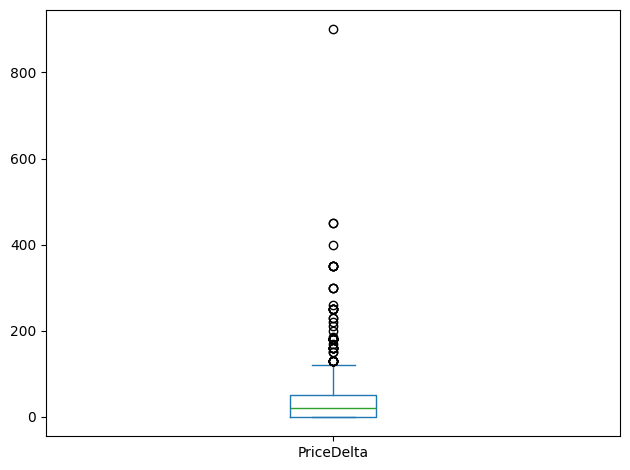

In [28]:
final_df["PriceDelta"].plot(kind="box")
print(final_df["PriceDelta"].describe())
plt.tight_layout()

plt.show()

In [68]:
# as given above about 75% of products have given less than 50 rupees
# discount and rest 25% are given more than that. Let's see how much
# each section cost us

print(final_df.loc[final_df["PriceDelta"] <= 50, "PriceDelta"].sum())
print(final_df.loc[final_df["PriceDelta"] > 50, "PriceDelta"].sum())

6909
19947


In [12]:
below_50 = final_df.loc[final_df["PriceDelta"] <= 50]
above_50 = final_df.loc[final_df["PriceDelta"] > 50]

In [16]:
below_50.groupby("Product_Category")["SellingPrice"].mean()

Product_Category
Bedsheet        295.000000
Belt            250.000000
Blanket         157.142857
Blouse          118.750000
Bra             138.571429
Cap             116.666667
Cycling Pant    125.000000
Dupatta         127.500000
Frock           420.000000
Half Pant       276.296296
Hand Gloves      80.000000
Handkerchief     39.166667
Inner Slips     125.000000
Kurti           350.000000
Leggings        300.000000
Mask             50.000000
Mosquito Net    200.714286
Nighties        395.000000
Panties          83.500000
Petticoat       205.000000
Pillow Cover     50.000000
Plazo           350.000000
Scarf           120.000000
Set             266.666667
Shirt           495.000000
Sindoor          10.000000
Socks            70.487805
T-Shirt         291.304348
Towel           117.692308
Track Pant      290.833333
Underwear       136.201550
Vest            151.041667
Wallet          120.000000
Name: SellingPrice, dtype: float64

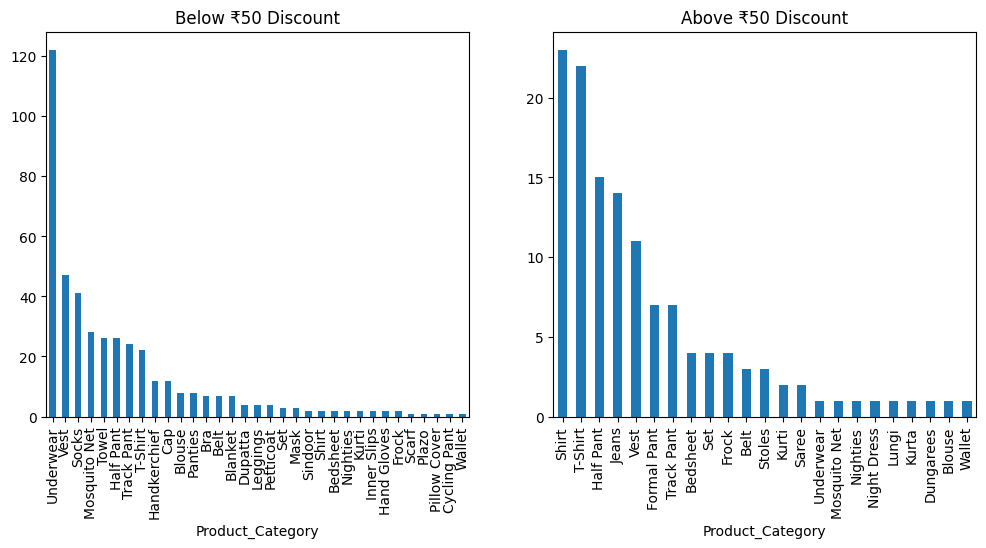

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

below_50.groupby("Product_Category")["InvoiceNo"].nunique().sort_values(ascending=False).plot(kind="bar", ax=axes[0])
axes[0].set_title("Below ₹50 Discount")

above_50.groupby("Product_Category")["InvoiceNo"].nunique().sort_values(ascending=False).plot(kind="bar", ax=axes[1])
axes[1].set_title("Above ₹50 Discount")

plt.show()

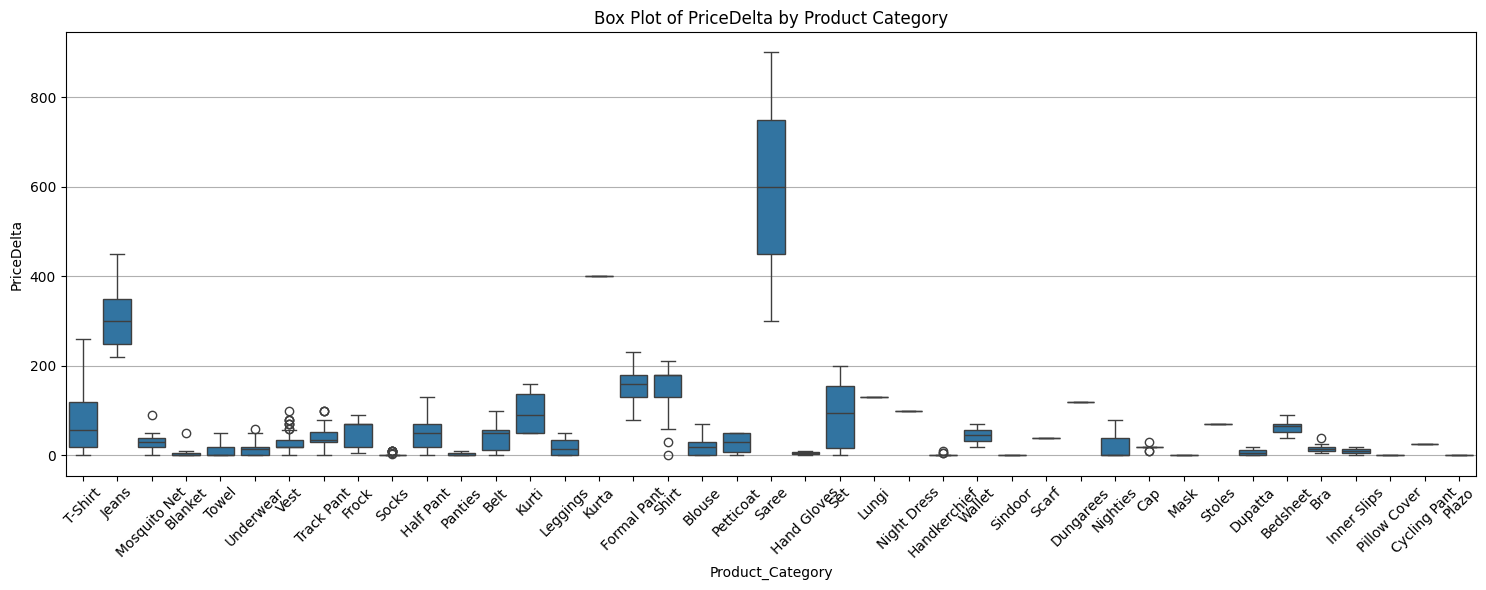

In [29]:
plt.figure(figsize=(15, 6))

sns.boxplot(x="Product_Category", y="PriceDelta", data=final_df)
plt.xticks(rotation=45)

plt.title("Box Plot of PriceDelta by Product Category")
plt.grid(axis="y")
plt.tight_layout()

plt.show()

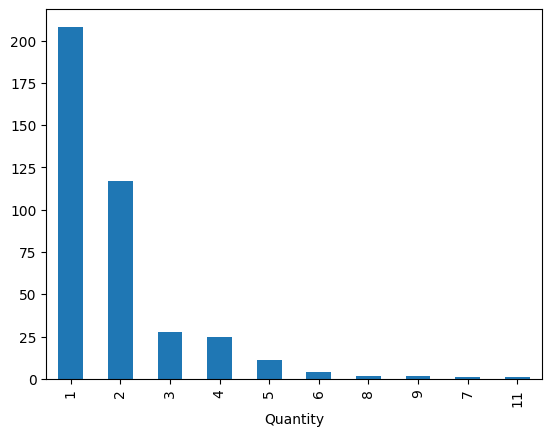

In [30]:
final_df.groupby("InvoiceNo")["Quantity"].sum().value_counts().plot(kind="bar")

plt.show()

In [19]:
# Data prep
temp_df = final_df.groupby("Product_Category")[
    ["QuantityPriceDelta", "Quantity"]
].sum().sort_values(by="QuantityPriceDelta", ascending=False)
temp_df = temp_df[temp_df["QuantityPriceDelta"] > 0]


# Updated function to support both manual and observed calls
def filter_and_plot(threshold):
    filtered_df = temp_df[temp_df["QuantityPriceDelta"] > threshold]
    ax = filtered_df["QuantityPriceDelta"].plot(kind='bar', figsize=(16, 6), color='skyblue')

    for i, (qty_price_delta, qty) in enumerate(zip(filtered_df["QuantityPriceDelta"], filtered_df["Quantity"])):
        ax.text(i, qty_price_delta + 100, f'{int(qty)}', ha='center', va='bottom', fontsize=9, rotation=0)

    for container in ax.containers:
        ax.bar_label(container, fmt='%.0f', label_type='center')

    plt.title("QuantityPriceDelta per Product Category (with Quantity info)")
    plt.ylabel("QuantityPriceDelta")
    plt.xlabel("Product Category")
    plt.tight_layout()
    plt.show()


# Use IntText instead of slider
threshold_widget = widgets.IntText(
    value=0,
    description='Above QuantityPriceDelta',
    style={'description_width': 'initial'}
)

# Bind with interact
widgets.interact(filter_and_plot, threshold=threshold_widget)

interactive(children=(IntText(value=0, description='Above QuantityPriceDelta', style=DescriptionStyle(descript…

<function __main__.filter_and_plot(threshold)>

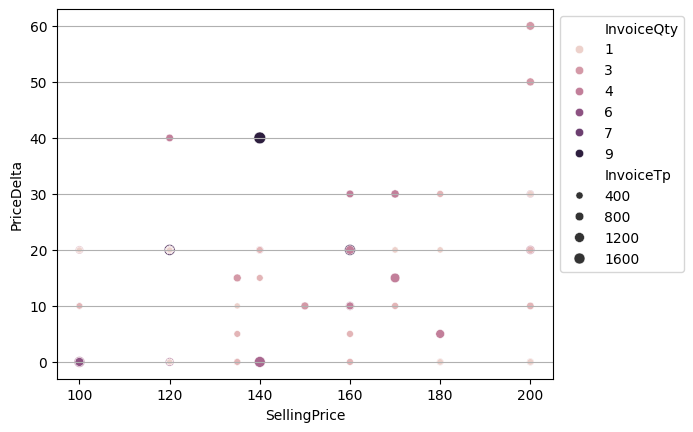

In [14]:
temp_df = final_df[final_df["Product_Category"] == "Underwear"]

ax = sns.scatterplot(
    data=temp_df,
    x="SellingPrice",
    y="PriceDelta",
    hue="InvoiceQty",    # color variation
    size="InvoiceTp",      # size variation
    # sizes=(20, 200)        # optional: control min and max marker sizes
)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.grid(axis="y")
plt.show()

This is my plot but it doesn't saw the number of points in that price delta. So i have decided to create facet grid for InvoiceQty and each grid it shows scatter plot between Selling Price and Price Delta with Hue as InvoiceTp and marker size as the amount of times that point occured in dataframe

Also time based plot with same scatter plot where x axis will be time and it will be facet grid. Thus seeing across time how priceDelta changes

In [20]:
temp_df = final_df[(final_df["Product_Category"] == "Underwear") & (final_df["SellingPrice"] == 100)]

<Axes: xlabel='PriceDelta', ylabel='count'>

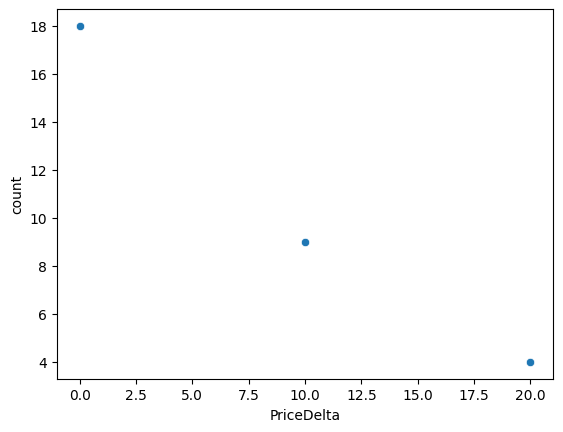

In [37]:
sns.scatterplot(temp_df["PriceDelta"].value_counts())

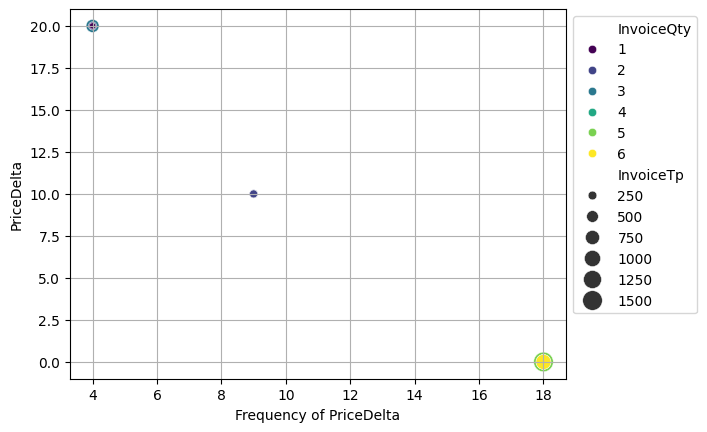

In [49]:
temp_df = final_df[(final_df["Product_Category"] == "Underwear") & (final_df["SellingPrice"] == 100)].copy()

temp_df['PriceDeltaCount'] = temp_df['PriceDelta'].map(temp_df['PriceDelta'].value_counts())

ax = sns.scatterplot(
    data=temp_df,
    x='PriceDeltaCount',
    y='PriceDelta',
    hue="InvoiceQty",    # color variation
    size="InvoiceTp",    # size variation
    sizes=(20, 200),     # controlling size of marker
    palette='viridis'
)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.grid()
plt.xlabel('Frequency of PriceDelta')
plt.ylabel('PriceDelta')
plt.show()

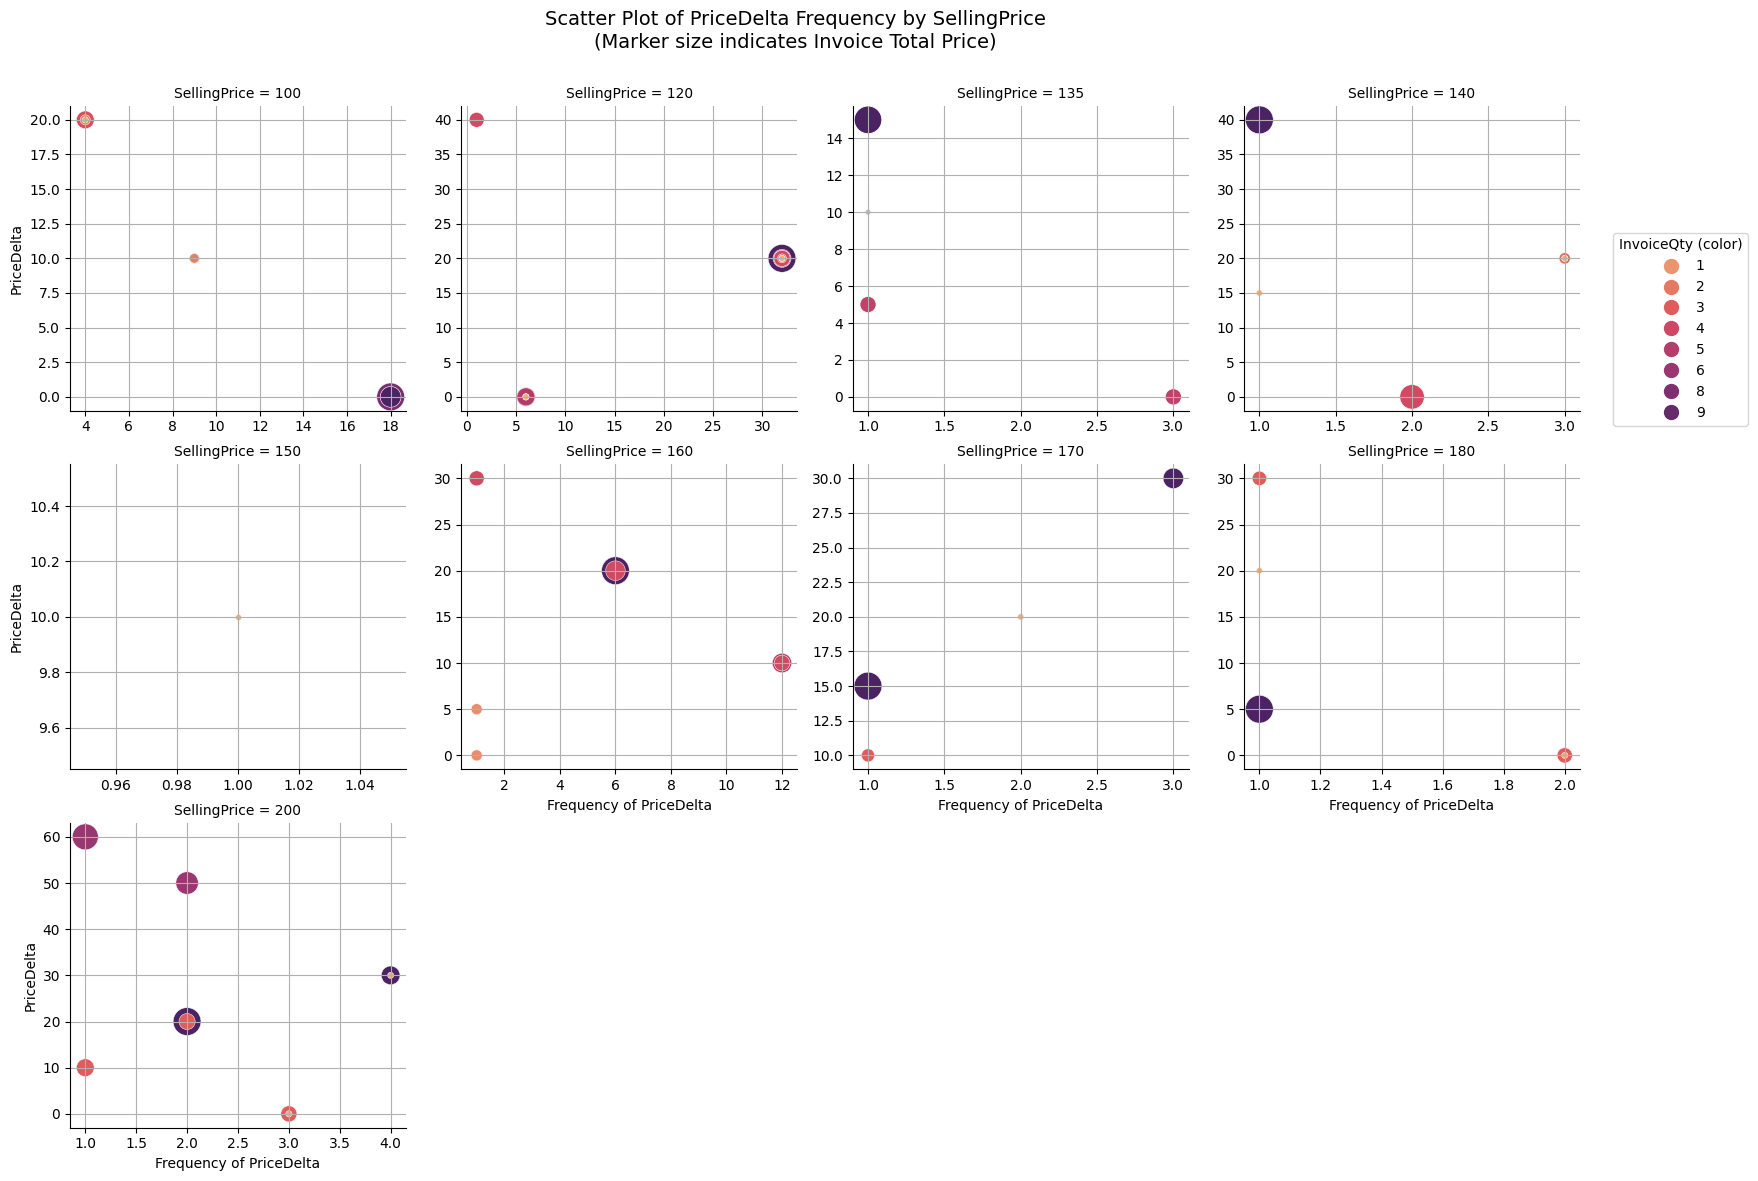

In [32]:
subset_df = final_df[final_df["Product_Category"] == "Underwear"].copy()

subset_df['PriceDeltaCount'] = (
    subset_df.groupby(['SellingPrice'])['PriceDelta']
    .transform(lambda x: x.map(x.value_counts()))
)

# FacetGrid setup
g = sns.FacetGrid(
    subset_df,
    col='SellingPrice',
    col_wrap=4,
    height=4,
    sharex=False,
    sharey=False
)

color_palette = "flare"

# Plot without auto-legend
g.map_dataframe(
    sns.scatterplot,
    x='PriceDeltaCount',
    y='PriceDelta',
    hue="InvoiceQty",
    size="InvoiceTp",
    sizes=(20, 400),
    palette=color_palette,
    legend=False  # Prevent seaborn from mixing hue+size in legend
)

# Add grid to all plots
for ax in g.axes.flatten():
    ax.grid(True)

# Create custom hue legend for InvoiceQty only
hue_levels = sorted(subset_df['InvoiceQty'].unique())
hue_palette = sns.color_palette(color_palette, len(hue_levels))
"""
hue_legend_handles = [
    mpatches.Patch(color=hue_palette[i], label=f'{level}')
    for i, level in enumerate(hue_levels)
]
"""

# Create custom legend handles with circular markers
hue_legend_handles = [
    mlines.Line2D([], [], marker='o', linestyle='None',
                  color=hue_palette[i], label=f'{level}',
                  markersize=10)
    for i, level in enumerate(hue_levels)
]

# Add hue legend only
g.fig.legend(
    handles=hue_legend_handles,
    title='InvoiceQty (color)',
    loc='upper right',
    bbox_to_anchor=(1.10, 0.8)
)

# Label and layout
g.set_axis_labels("Frequency of PriceDelta", "PriceDelta")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Scatter Plot of PriceDelta Frequency by SellingPrice\n(Marker size indicates Invoice Total Price)', fontsize=14)

plt.savefig("scatterplotpricedelta.png", bbox_inches='tight')
plt.show()

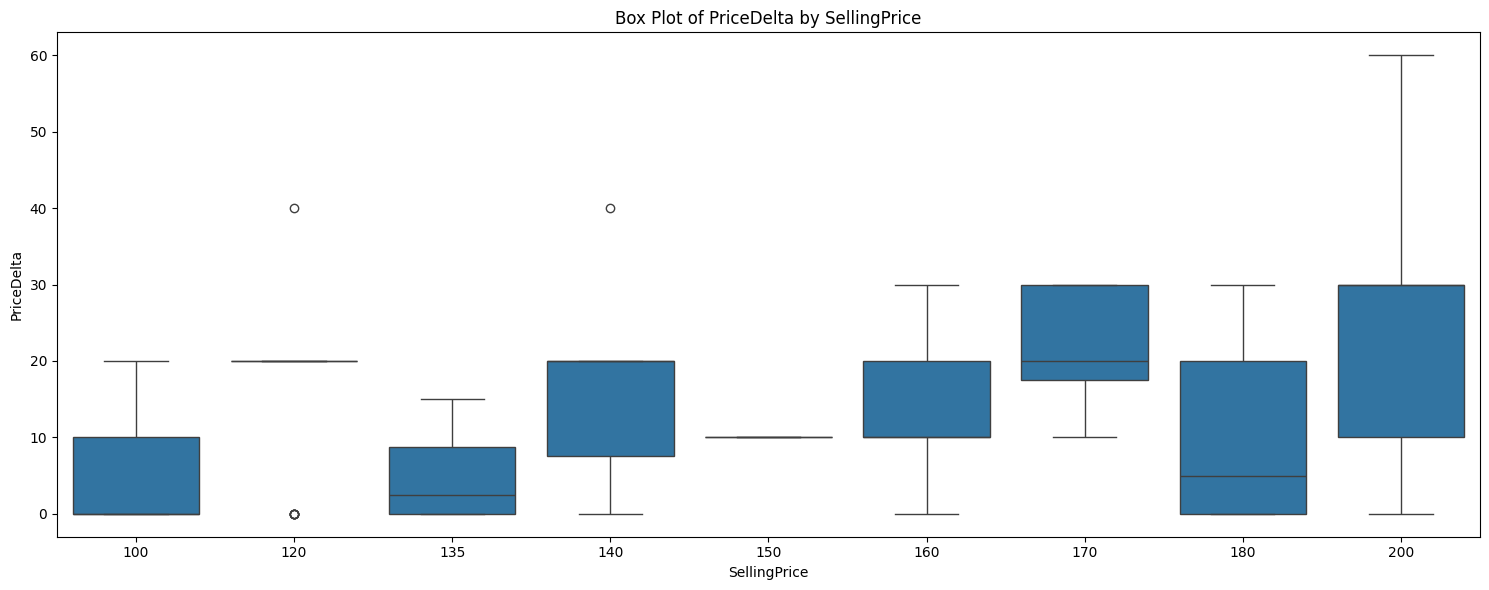

In [27]:
plt.figure(figsize=(15, 6))

sns.boxplot(x="SellingPrice", y="PriceDelta", data=subset_df)

plt.title("Box Plot of PriceDelta by SellingPrice")
plt.tight_layout()

plt.show()

In [115]:
# product wise analysis
# let's find which feature to use as distinctor in each product category

final_df['Product_Category'].sort_values().unique()

array(['Bedsheet', 'Belt', 'Blanket', 'Blouse', 'Bra', 'Cap',
       'Cycling Pant', 'Dungarees', 'Dupatta', 'Formal Pant', 'Frock',
       'Half Pant', 'Hand Gloves', 'Handkerchief', 'Inner Slips', 'Jeans',
       'Kurta', 'Kurti', 'Leggings', 'Lungi', 'Mask', 'Mosquito Net',
       'Night Dress', 'Nighties', 'Panties', 'Petticoat', 'Pillow Cover',
       'Plazo', 'Saree', 'Scarf', 'Set', 'Shirt', 'Sindoor', 'Socks',
       'Stoles', 'T-Shirt', 'Towel', 'Track Pant', 'Underwear', 'Vest',
       'Wallet'], dtype=object)

In [7]:
# from looking at individual categories subset, all them can be internally distinguish by
# description. Just need to remove the colour if present

def get_product_feature(desc_string):
    colors = ["Black", "Blue", "Dark Green", "Brown", "Grey", "Purple", "White", "Red"]
    matched_color = None
    for color in colors:
        if color in desc_string:
            matched_color = color
            desc_string = desc_string.replace(matched_color, "")
            break

    cleaned_details = ' '.join(desc_string.split())
    return cleaned_details


final_df["Product_Feature"] = final_df["Description"].apply(get_product_feature)

In [171]:
category_df = final_df[final_df["Product_Category"] == "Mosquito Net"].copy()

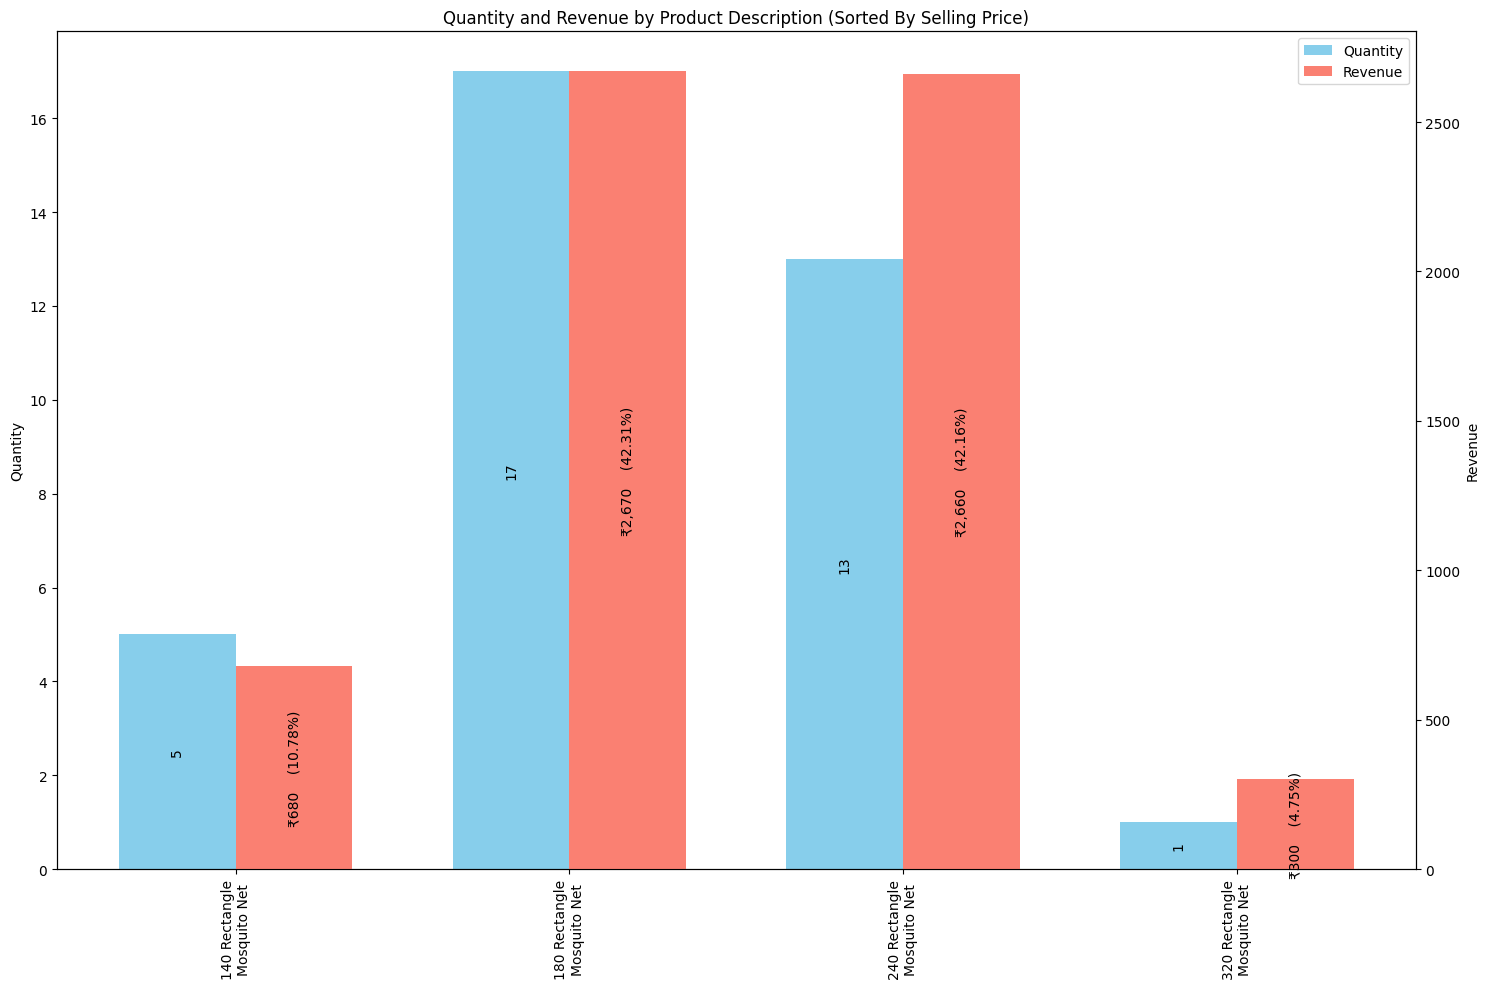

In [172]:
product_category_df = category_df.groupby("Product_Feature").agg(
    Quantity=("Quantity", "sum"),
    Revenue=("TotalPrice", "sum"),
    SP=("SellingPrice", lambda x: list(x)[0])
).sort_values(by="SP", ascending=True)

categories = list(product_category_df.index)
values1 = list(product_category_df["Quantity"])
values2 = list(product_category_df["Revenue"])
total_rev = sum(values2)

x = np.arange(len(categories))  # the label locations
width = 0.35  # width of the bars

fig, ax1 = plt.subplots(figsize=(15, 10))

bars1 = ax1.bar(x - width/2, values1, width, label='Quantity', color='skyblue')
ax2 = ax1.twinx()
bars2 = ax2.bar(x + width/2, values2, width, label='Revenue', color='salmon')

# Add labels on bars
ax1.bar_label(bars1, rotation=90, label_type="center")  # For Quantity
ax2.bar_label(
    bars2,
    labels=[f"{format_currency(v)}    ({round((v/total_rev) * 100, 2)}%)" for v in values2],
    rotation=90,
    label_type="center"
)  # For Revenue

# Labels and titles
ax1.set_ylabel('Quantity')
ax2.set_ylabel('Revenue')
ax1.set_title('Quantity and Revenue by Product Description (Sorted By Selling Price)')
ax1.set_xticks(x)

wrapped_labels = [textwrap.fill(label, 20) for label in categories]  # wrap at 10 characters
ax1.set_xticklabels(wrapped_labels, rotation=90)

# Legends
custom_legend = [
    mpatches.Patch(facecolor='skyblue', label='Quantity'),
    mpatches.Patch(facecolor='salmon', label='Revenue')
]

ax1.legend(handles=custom_legend)

plt.tight_layout()
plt.show()

In [173]:
features = category_df["Product_Feature"].sort_values().unique()

# Map product names to numeric labels
product_mapping = {prod: i + 1 for i, prod in enumerate(features)}
inverse_mapping = {v: k for k, v in product_mapping.items()}

category_df["Product_Feature_Number"] = category_df["Product_Feature"].map(product_mapping)

In [174]:
all_dates = final_df["PaymentDateTime"].dt.date.sort_values().unique()

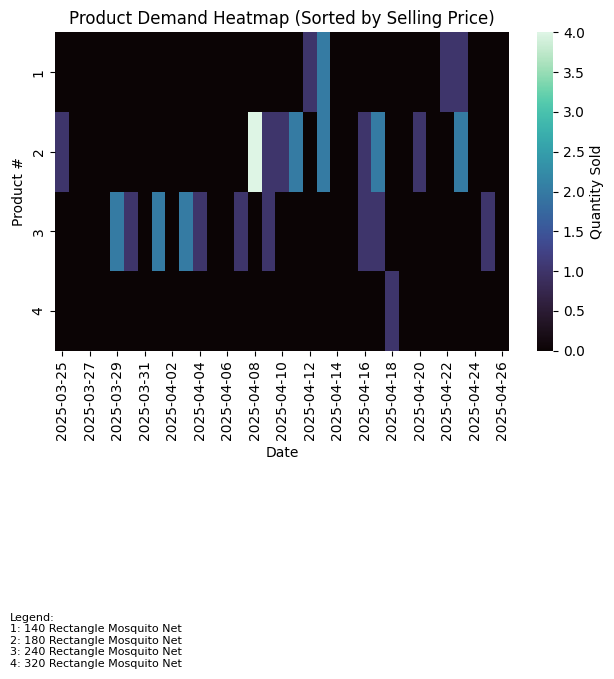

In [175]:
cluster_time_df = category_df.groupby(
    [category_df["PaymentDateTime"].dt.date, "Product_Feature_Number"]
)["Quantity"].sum().unstack().fillna(0)

# Sort by Selling Price
sorted_products = cluster_time_df.columns.sort_values()

cluster_time_df = cluster_time_df.reindex(all_dates, fill_value=0)

# Plot the heatmap
# plt.figure(figsize=(12, 6))
sns.heatmap(cluster_time_df.T, cmap="mako", annot=False, cbar_kws={'label': 'Quantity Sold'})
plt.title("Product Demand Heatmap (Sorted by Selling Price)")
plt.xlabel("Date")
plt.ylabel("Product #")
plt.xticks(rotation=90)

# Add legend for product mapping
legend_text = "\n".join([f"{num}: {name}" for num, name in inverse_mapping.items()])
plt.gcf().text(0.02, -0.4, f"Legend:\n{legend_text}", fontsize=8, ha='left')

plt.tight_layout()
plt.show()

In [176]:
nanvals = sum(category_df["Size"].isna() * 1)

print(f"Number rows where size is nan -> {nanvals}")
print(f"Percentage of that -> {nanvals / category_df['Size'].size}")

Number rows where size is nan -> 0
Percentage of that -> 0.0


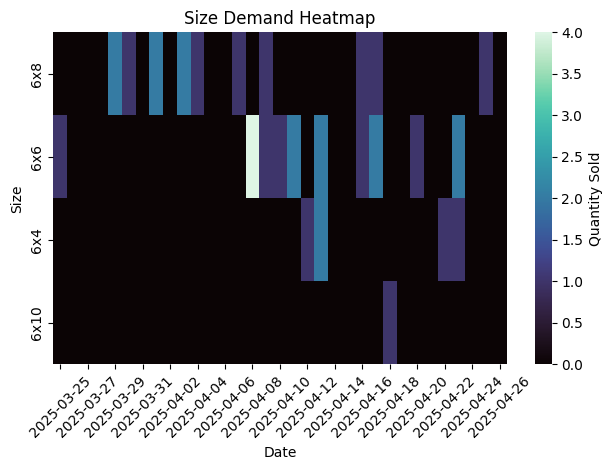

In [177]:
size_time_df = category_df.groupby([category_df["PaymentDateTime"].dt.date, "Size"])["Quantity"].sum().unstack().fillna(0)
size_time_df = size_time_df.loc[
    size_time_df.sort_index().index,
    pd.Series(size_time_df.columns).sort_values(ascending=False)
]

size_time_df = size_time_df.reindex(all_dates, fill_value=0)

# Create sorted heatmap
sns.heatmap(
    size_time_df.T,
    cmap='mako',
    annot=False,
    cbar_kws={'label': 'Quantity Sold'}
)

plt.title('Size Demand Heatmap')
plt.xlabel('Date')
plt.ylabel('Size')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

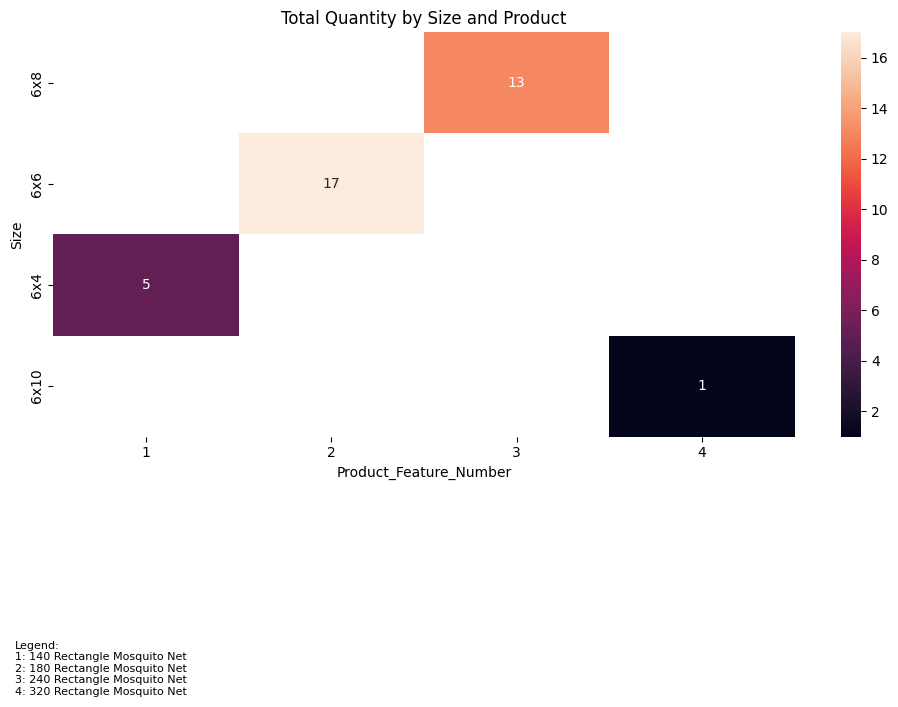

In [178]:
# Size-price matrix
size_price = category_df.pivot_table(index='Size', columns='Product_Feature_Number', values='Quantity', aggfunc='sum')
size_price = size_price.loc[
    size_price.index.sort_values(ascending=False),
    size_price.columns.sort_values()
]

plt.figure(figsize=(10, 5))

sns.heatmap(size_price, annot=True, fmt=".0f")

# Add legend for product mapping
legend_text = "\n".join([f"{num}: {name}" for num, name in inverse_mapping.items()])
plt.gcf().text(0.02, -0.4, f"Legend:\n{legend_text}", fontsize=8, ha='left')

plt.title('Total Quantity by Size and Product')

plt.tight_layout()
plt.show()

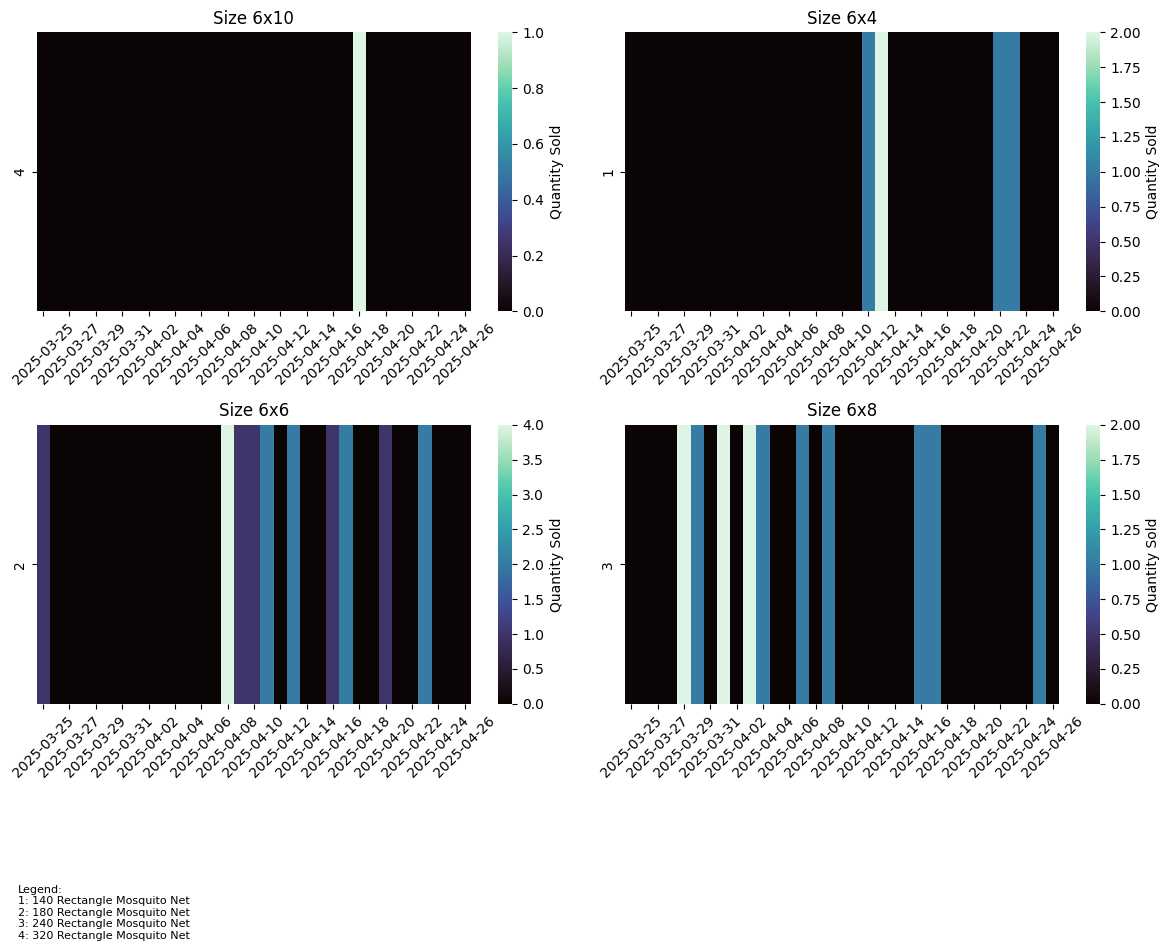

In [179]:
sizes = category_df[~category_df["Size"].isna()]["Size"].sort_values().unique()

n_cols = 2
n_rows = math.ceil(len(sizes) / n_cols)

# Dynamically scale figure size (e.g., 6x4 inches per subplot)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows))

i = 0
for _, size in enumerate(sizes):
    ax = axes[i // 2, i % 2]
    k = category_df[category_df["Size"] == size]
    k = k.groupby([k["PaymentDateTime"].dt.date, k["Product_Feature_Number"]])["Quantity"].sum().unstack().fillna(0)
    k = k.reindex(all_dates, fill_value=0)
    k.columns = np.array(k.columns)
    sns.heatmap(k.T, cmap="mako", annot=False, cbar_kws={'label': "Quantity Sold"}, ax=ax)
    ax.set_title(f'Size {size}')
    ax.tick_params(axis='x', rotation=45)
    ax.set_xlabel('')
    i += 1

if i % 2 != 0:
    axes[i // 2, 1].set_axis_off()

# Add legend for product mapping
legend_text = "\n".join([f"{num}: {name}" for num, name in inverse_mapping.items()])
plt.gcf().text(0.02, -0.18, f"Legend:\n{legend_text}", fontsize=8, ha='left')

plt.tight_layout()
plt.show()